Some preprocessing stuff

In [1]:
#Imports the print function from newer versions of python
from __future__ import print_function

%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [0]:
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
zip_path = "/content/drive/My Drive/Object_Detection_from_Satellite_Imagery_Data/SIMD.zip"
!unzip '$zip_path' -d ./data/
!unzip -q 'data/SIMS dataset/images.zip' -d data/
!unzip -q 'data/SIMS dataset/Annotations_in_3_formats.zip' -d data

Archive:  /content/drive/My Drive/Object_Detection_from_Satellite_Imagery_Data/SIMD.zip
  inflating: ./data/SIMS dataset/test.txt  
  inflating: ./data/SIMS dataset/training.txt  
  inflating: ./data/SIMS dataset/validation.txt  
  inflating: ./data/SIMS dataset/Assignment-2_modified scope.pdf  
  inflating: ./data/SIMS dataset/Annotations_in_3_formats.zip  
  inflating: ./data/SIMS dataset/images.zip  


In [0]:
import os, csv, PIL

def create_csv(txt_path, output_path, class_mapping):
  """
  Creates a csv file that can be used with keras-retinanet csv generator
  (Dependencies: [os, csv, PIL])
  """
  # A subfunction to read annotations file
  def read_ann(ann_path):
    with open(ann_path, 'r') as f:
      lines = f.readlines()
    return lines

  # A subfunction to convert percentage centre 
  # co-ordinates to x1, y1, x2, y2 absolute co-ordinates
  def get_abs_coord(coords, im_w, im_h):
    n_coords = coords.copy()
    n_coords[0] = (coords[0] - (coords[2]/2)) * im_w
    n_coords[2] = n_coords[0] + (coords[2] * im_w)
    n_coords[1] = (coords[1] - (coords[3]/2)) * im_h
    n_coords[3] = n_coords[1] + (coords[3] * im_h)

    return list(map(int, n_coords))

  # Class ID to name mapping
  id_to_name = class_mapping

  # create_csv continues.
  # A bit of mangling with the path
  root = txt_path.split('/')[0]
  # CSV list to keep track of the lines needed to be written to the csv
  csv_list = []
  with open(txt_path, 'r') as f:
    line = f.readline()
    while line:
      # Get images path
      im_path = line.strip()
      abs_im_path = root + '/' + "/".join(line.strip().split('/')[1:])
      # Get path of annotations for the image
      im_txt_path = os.path.splitext(abs_im_path)[0] + '.txt'
      # Get the annotations
      anns = read_ann(im_txt_path)
      for ann in anns:
        items = ann.strip().split(' ')
        c_id, bb = int(items[0]), list(map(float, items[1:]))
        # Get the size of the image
        w, h = PIL.Image.open(abs_im_path).size
        # Get absolute co-ordinates
        bb = get_abs_coord(bb, w, h)
        # Row for csv file, converting x,y,w,h to x,y,x1, y1
        csv_list.append([im_path, *bb, id_to_name[c_id]])
      # Read next line
      line = f.readline()

    with open(output_path, 'w', newline="") as f:
      writer = csv.writer(f)
      writer.writerows(csv_list)
        

In [0]:
class_mapping = ['Car', 'Truck', 'Van', 'LongVehicle', 'Bus', 
                'Airliner', 'Propeller Aircraft', 'Trainer Aircraft', 'Chartered Aircraft',
                'Fighter Aircraft', 'Others', 'Stair Truck', 'Pushback Truck',
                'Helicopter', 'Boat']
class_mapping = dict(enumerate(class_mapping))

create_csv('data/SIMS dataset/training.txt', 'data/training.csv', class_mapping)
create_csv('data/SIMS dataset/test.txt', 'data/test.csv', class_mapping)
create_csv('data/SIMS dataset/validation.txt', 'data/validation.csv', class_mapping)

class_csv = list(map(lambda x: (x[1], x[0]), class_mapping.items()))

with open('data/classes.csv', 'w', newline="") as f:
  writer = csv.writer(f)
  writer.writerows(class_csv)

In [7]:
!git clone https://github.com/fizyr/keras-retinanet
!pip install ./keras-retinanet/
!mv keras-retinanet/* .
!rm -r keras-retinanet
!python setup.py build_ext --inplace

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5711 (delta 0), reused 1 (delta 0), pack-reused 5705
Receiving objects: 100% (5711/5711), 13.37 MiB | 14.15 MiB/s, done.
Resolving deltas: 100% (3831/3831), done.
Processing ./keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170126 sha256=0309d4ef14e93afb08be05ab97bd78ce77ca9a5c08d686c46fc1763cf49b7135
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=52aae0250b3a27a3f890830ce1f573b08f6353779fca80d7316529c11f99af99
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet
running build_ext
cytho

In [8]:
from keras_retinanet import models
import keras

model = models.backbone('resnet50').retinanet(num_classes=15)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [9]:
import keras_retinanet
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal()
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model.summary()

Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [0]:
from keras_retinanet.preprocessing import csv_generator
TrainGenerator = csv_generator.CSVGenerator('data/training.csv', 'data/classes.csv')
TestGenerator = csv_generator.CSVGenerator('data/test.csv', 'data/classes.csv')
ValidationGenerator = csv_generator.CSVGenerator('data/validation.csv', 'data/classes.csv')

In [13]:
history = model.fit_generator(TrainGenerator)

Epoch 1/1
 616/3233 [====>.........................] - ETA: 9:29 - loss: 3.6989 - regression_loss: 2.7275 - classification_loss: 0.9714

/content/keras_retinanet/preprocessing/generator.py:181: UserWarning: Image data/./images/0503.jpg with id 680 (shape (768, 1024, 3)) contains the following invalid boxes: [[ -1. 309.  19. 346.]].
  annotations['bboxes'][invalid_indices, :]


1048/3233 [========>.....................] - ETA: 7:54 - loss: 3.5236 - regression_loss: 2.6160 - classification_loss: 0.9076

/content/keras_retinanet/preprocessing/generator.py:181: UserWarning: Image data/./images/2218.jpg with id 1892 (shape (768, 1024, 3)) contains the following invalid boxes: [[ -3. 177. 110. 306.]].
  annotations['bboxes'][invalid_indices, :]


3233/3233 [==============================] - 702s 217ms/step - loss: 3.0909 - regression_loss: 2.2930 - classification_loss: 0.7979


In [14]:
 from keras_retinanet.callbacks.eval import Evaluate

mAP_callback = Evaluate(ValidationGenerator)
callbacks = [mAP_callback]
callbacks

In [0]:
from keras_retinanet.utils.eval import evaluate

evaluate(TestGenerator, model)

In [0]:
model.save('m.h5')

In [18]:
!keras_retinanet/bin/convert_model.py m.h5 m_i.h5

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2020-05-14 18:00:28.095491: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-14 18:00:28.098082: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-05-14 18:00:28.098146: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 40ad8cc6ee5f
2020-05-14 18:00:28.098168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 40ad8cc6ee5f
2020-05-14 18:00:28.098275: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 418.67.0
2020-05-14 18:00:28.098386: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 418.67.0
2020-05-14 18:00:28.098424: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc

In [0]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

In [20]:
model_path = os.path.join('m_i.h5')

# load retinanet model
model_ = models.load_model(model_path, backbone_name='resnet50')

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
labels_to_names=class_mapping

processing time:  0.0777273178100586


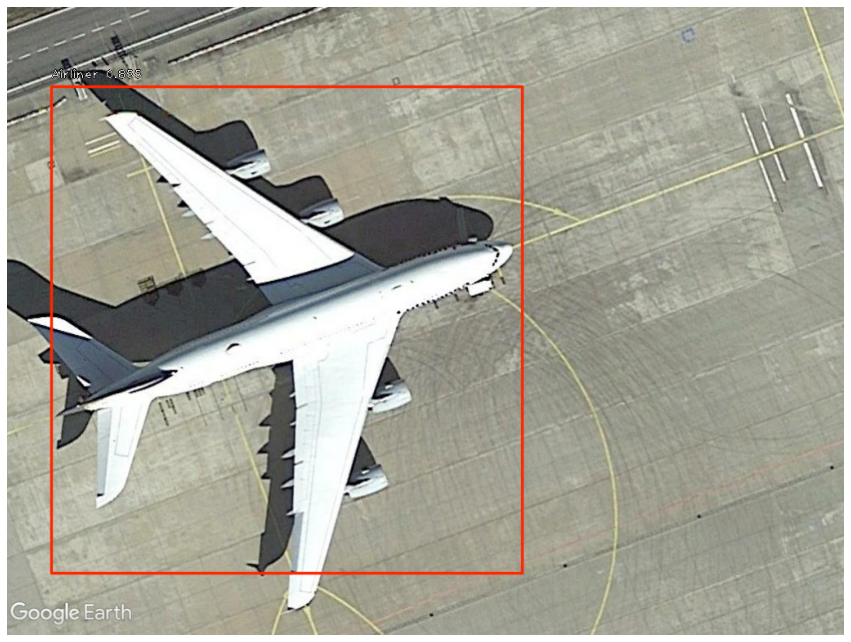

In [28]:
# load image
image = read_image_bgr('data/./images/1532.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model_.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

processing time:  0.07439827919006348


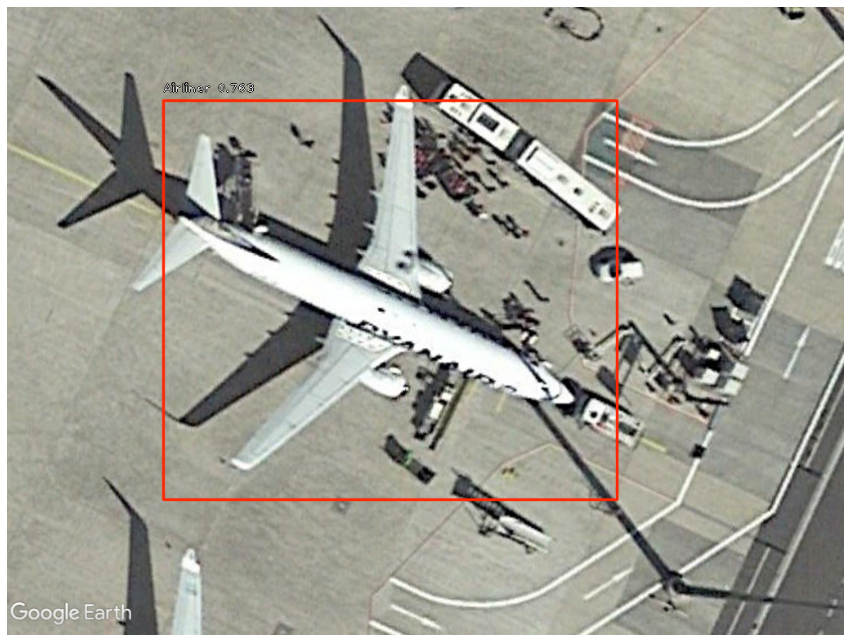

In [41]:
# load image
image = read_image_bgr('data/./images/1555.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model_.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()